In [21]:
import numpy as np
import pandas as pd
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
from scipy.integrate import odeint
from scipy.optimize import minimize
from numpy.random import normal

# Dataset: Johns Hopkins CSSE COVID-19 Dataset 
# (GitHub Repository: https://github.com/CSSEGISandData/COVID-19).

In [18]:
COUNTRY="Vietnam" # looked at four countries: "Thailand", "Vietnam", "Cambodia", "Brunei"


[DEBUG] Data Verification:
First day active cases: 0
Last day active cases: 57
Max active cases: 163
Number of unique active case values: 60

[DEBUG] Testing Data Verification:
Testing period start: 2020-03-23 00:00:00
Testing period end: 2020-05-22 00:00:00
Number of testing days: 61
Testing data active cases range: 36 to 163

[DEBUG] Calibrated Parameters:
Effective R0: 1.3407
Beta (Non-quarantined): 0.1000
Beta (Quarantined): 0.0250
Gamma (Non-quarantined): 0.0500
Gamma (Quarantined): 0.0650
Quarantine Ratio: 0.4193

[DEBUG] Training Data Statistics:
Average daily growth rate: 0.0958
Average daily recovery rate: 0.1343
Peak active cases: 0.2963

[DEBUG] Calibrated Parameters:
Effective R0: 1.3407
Beta (Non-quarantined): 0.1000
Beta (Quarantined): 0.0250
Gamma (Non-quarantined): 0.0500
Gamma (Quarantined): 0.0650
Quarantine Ratio: 0.4193

[DEBUG] Training Data Statistics:
Average daily growth rate: 0.0958
Average daily recovery rate: 0.1343
Peak active cases: 0.2963

[DEBUG] Initial

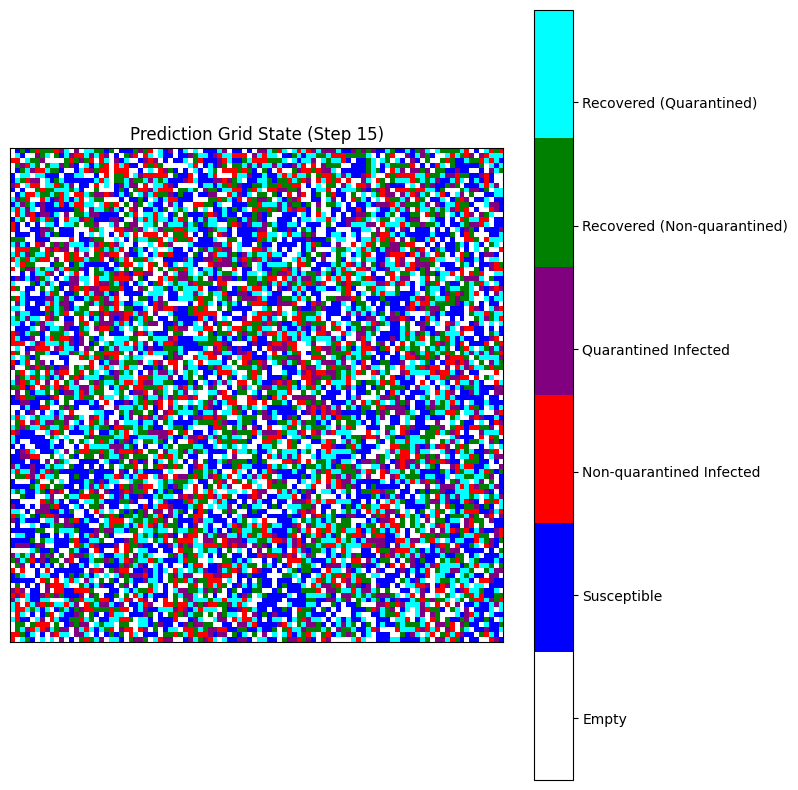

Day 20: Active cases = 0.1920
Day 30: Active cases = 0.1066


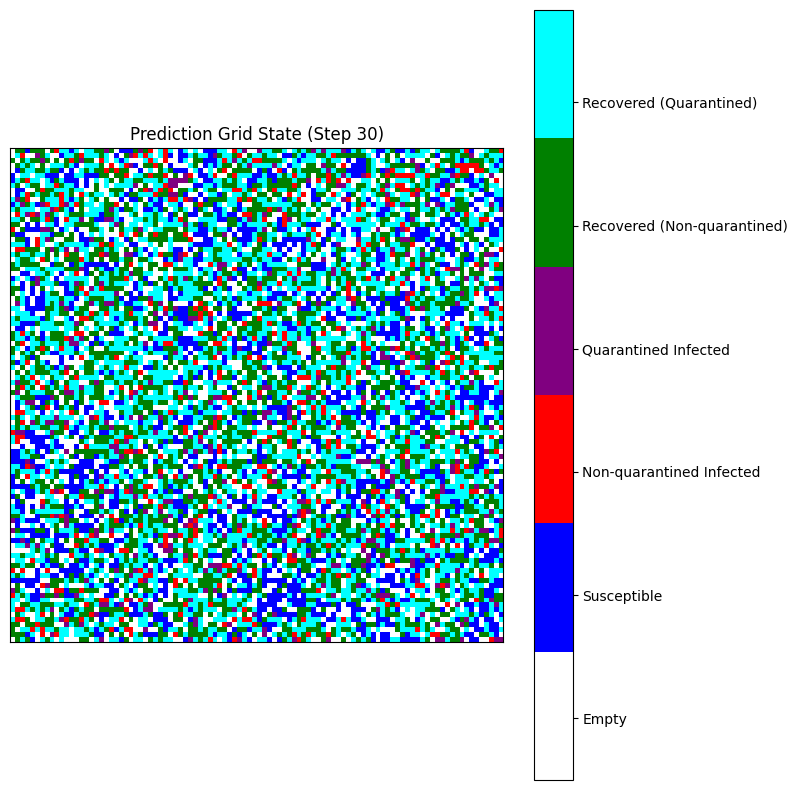

Day 40: Active cases = 0.0539


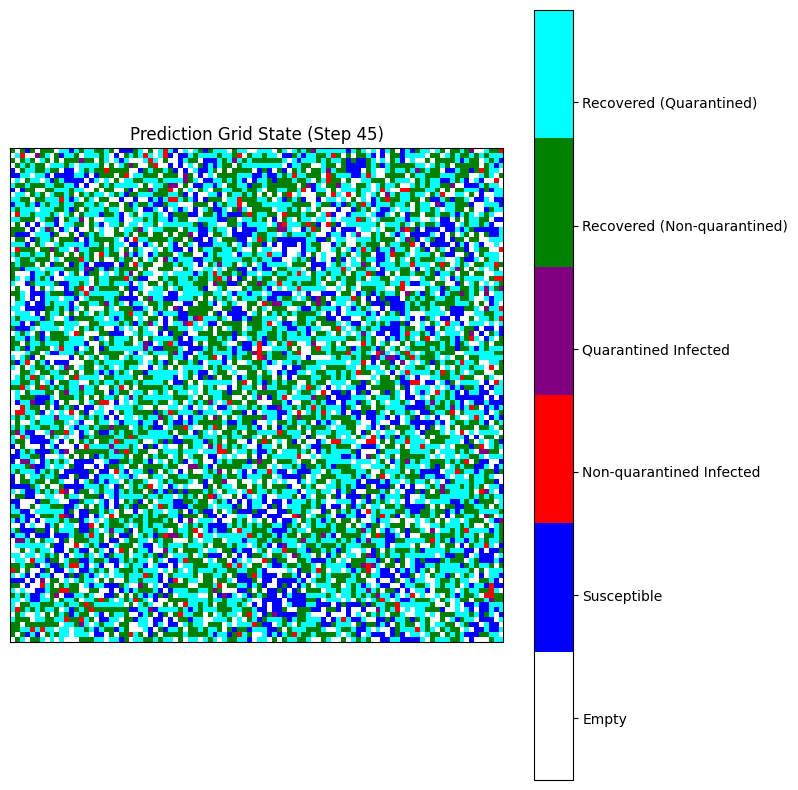

Day 50: Active cases = 0.0267
Day 60: Active cases = 0.0134


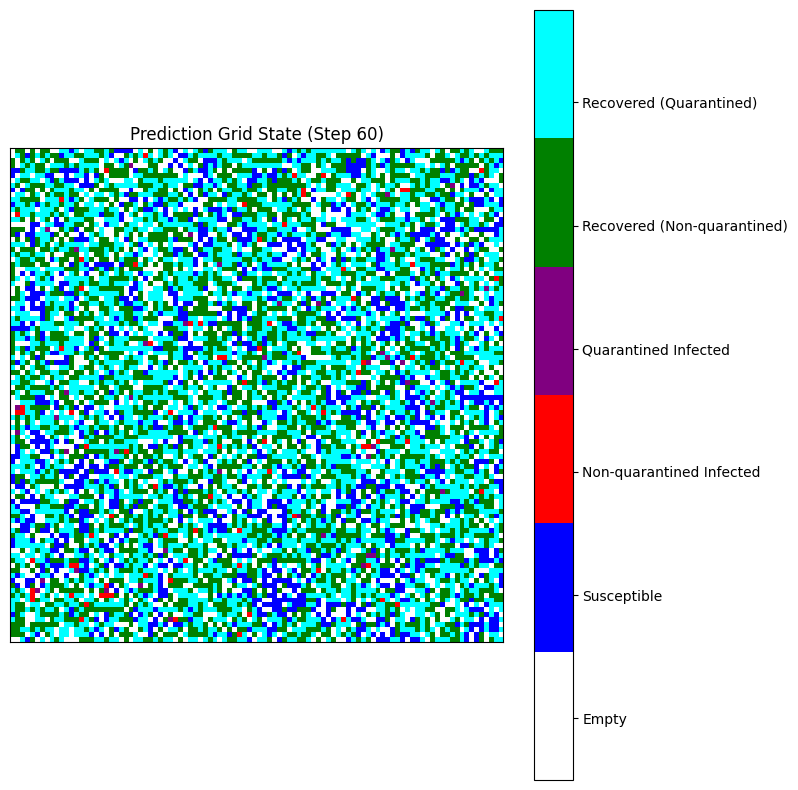


[DEBUG] Plotting Data Verification:
Training end date: 2020-03-22 00:00:00
Testing start date: 2020-03-23 00:00:00
Last training point (Active): 0.2963
First testing point (Active): 0.3272
First prediction point (Active): 0.2720


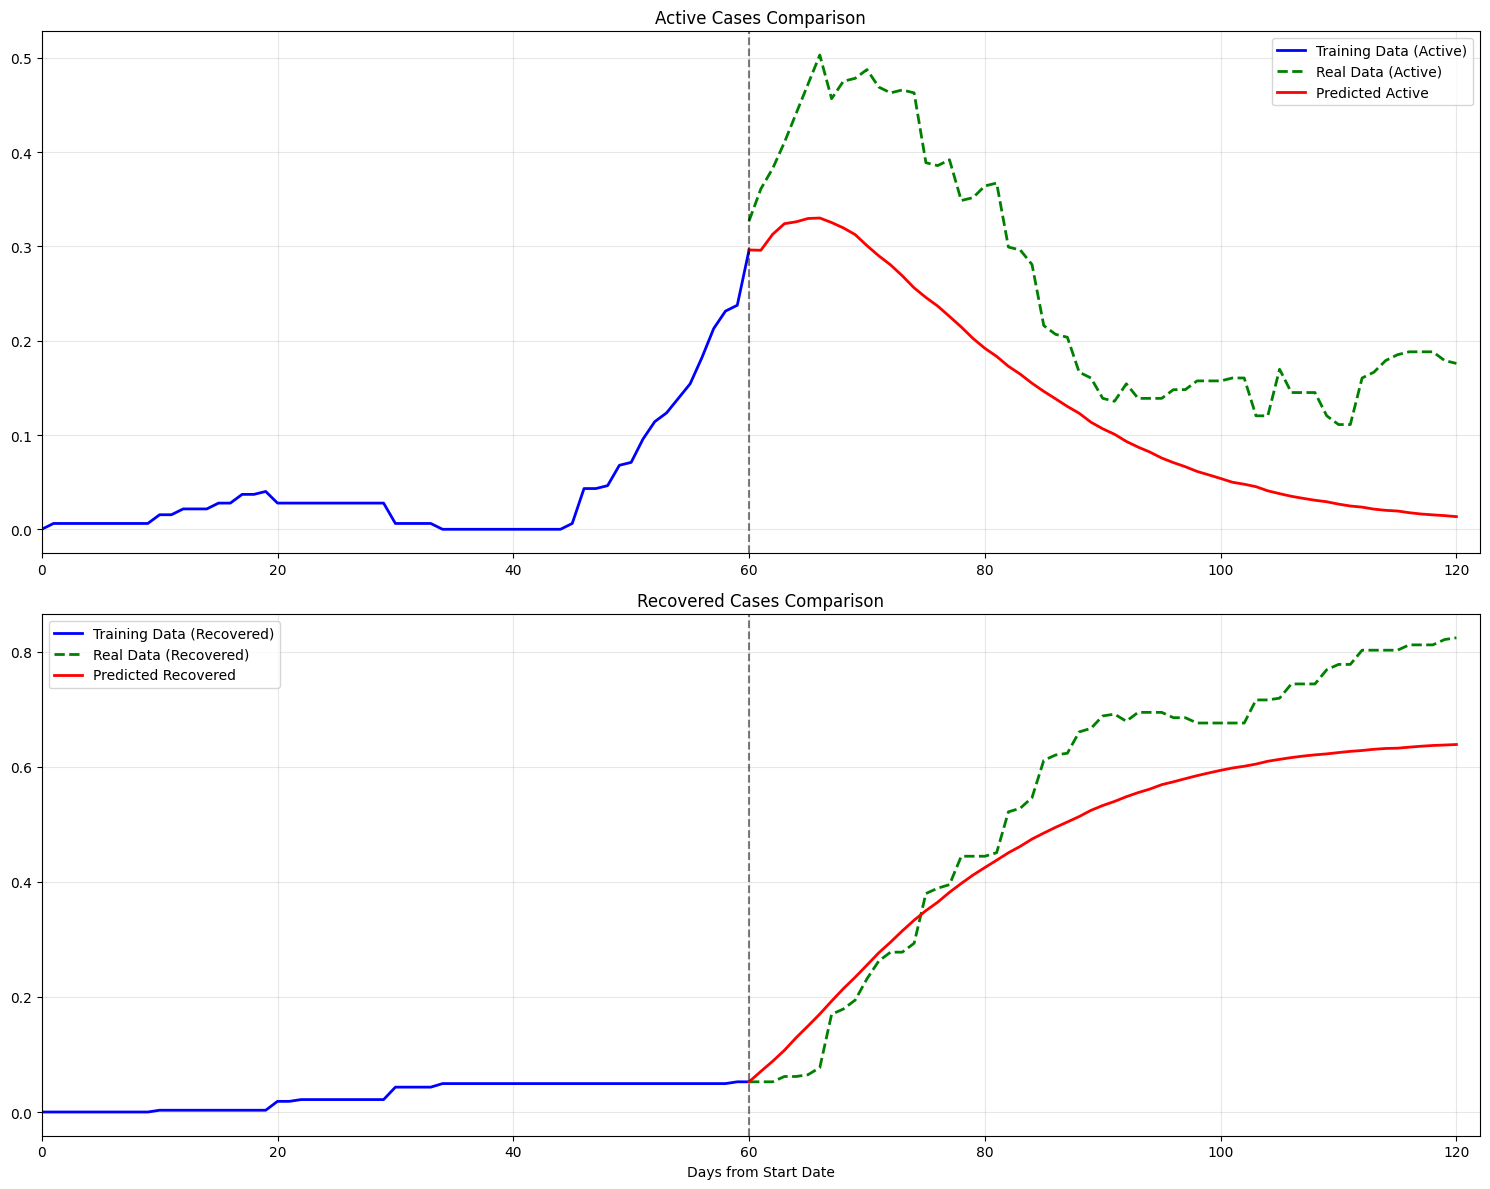


[DEBUG] Data Ranges:
Real Active: min=0.1111, max=0.5031
Pred Active: min=0.0134, max=0.3302
Real Recovered: min=0.0525, max=0.8241
Pred Recovered: min=0.0525, max=0.6386

[DEBUG] Active Metrics Details:
Sum of Squared Residuals: 0.9824
Total Sum of Squares: 1.0331
Variance in real data: 0.0169
Mean absolute error: 0.1178

[DEBUG] Recovered Metrics Details:
Sum of Squared Residuals: 0.7444
Total Sum of Squares: 3.8336
Variance in real data: 0.0628
Mean absolute error: 0.0956

Prediction Error Metrics:
Active_MSE: 0.0161
Active_RMSE: 0.1269
Active_MAE: 0.1178
Active_R2: 0.0491
Recovered_MSE: 0.0122
Recovered_RMSE: 0.1105
Recovered_MAE: 0.0956
Recovered_R2: 0.8058


In [19]:
class CovidPredictionSimulator:
    # Grid state constants
    EMPTY = 0
    SUSCEPTIBLE = 1
    INFECTED_NON_QUARANTINED = 2
    INFECTED_QUARANTINED = 3
    RECOVERED_NON_QUARANTINED = 4
    RECOVERED_QUARANTINED = 5

    def __init__(self, data_path: str, country: str, start_date: str, end_date: str):
        """
        Initialize simulator using first 60 days for training and remaining for prediction.

        Parameters:
        -----------
        data_path: Path to COVID-19 data CSV
        country: Country to analyze
        start_date: Start date in YYYY-MM-DD format
        end_date: End date in YYYY-MM-DD format
        """
        self.data = pd.read_csv(data_path, parse_dates=['Date'])
        self.country = country
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)

        # Set training period (first 60 days)
        self.training_end_date = self.start_date + timedelta(days=60)

        # Load and process data
        self._process_country_data()

        # Calculate parameters from training data
        self.calculate_daily_parameters()

        # Initialize simulation
        self.initialize_simulation_params()

    def _process_country_data(self):
        """Process and validate country-specific data."""
        # Get country data and aggregate by date
        self.country_data = self.data[
            (self.data['Country/Region'] == self.country) &
            (self.data['Date'] >= self.start_date) &
            (self.data['Date'] <= self.end_date)
            ].groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

        # Calculate active cases
        self.country_data['Active'] = (
            self.country_data['Confirmed'] -
            self.country_data['Deaths'] -
            self.country_data['Recovered']
        ).clip(0)  # Ensure no negative active cases

        # Add debug printing to verify data
        print("\n[DEBUG] Data Verification:")
        print(f"First day active cases: {self.country_data['Active'].iloc[0]}")
        print(f"Last day active cases: {self.country_data['Active'].iloc[-1]}")
        print(f"Max active cases: {self.country_data['Active'].max()}")
        print(f"Number of unique active case values: {len(self.country_data['Active'].unique())}")

        # Calculate new cases using difference
        self.country_data['New_Cases'] = self.country_data['Confirmed'].diff().fillna(0)

        # Split into training and testing periods
        self.training_data = self.country_data[
            self.country_data['Date'] <= self.training_end_date
            ].copy()

        self.testing_data = self.country_data[
            self.country_data['Date'] > self.training_end_date
            ].copy()

        # Verify testing data
        print("\n[DEBUG] Testing Data Verification:")
        print(f"Testing period start: {self.testing_data['Date'].iloc[0]}")
        print(f"Testing period end: {self.testing_data['Date'].iloc[-1]}")
        print(f"Number of testing days: {len(self.testing_data)}")
        print(f"Testing data active cases range: {self.testing_data['Active'].min()} to {self.testing_data['Active'].max()}")

        # Calculate proportions for proper scaling
        total_population = self.country_data['Confirmed'].max()
        self.training_data['Active_Ratio'] = self.training_data['Active'] / total_population
        self.training_data['Recovered_Ratio'] = self.training_data['Recovered'] / total_population
        self.testing_data['Active_Ratio'] = self.testing_data['Active'] / total_population
        self.testing_data['Recovered_Ratio'] = self.testing_data['Recovered'] / total_population

    def calculate_daily_parameters(self):
        """Calculate transmission and recovery parameters using refined approach."""
        window = 14  # Use 14-day window for better trend capture
        
        # Calculate active cases and susceptible population
        active_cases = self.training_data['Active'].replace(0, 1)
        total_population = self.country_data['Confirmed'].max()
        susceptible = total_population - self.training_data['Confirmed']
        susceptible = susceptible.replace(0, 1)
        
        # Calculate effective reproduction number (R0) from training data
        growth_rate = (self.training_data['New_Cases'] / active_cases).rolling(window=window).mean()
        effective_r0 = growth_rate.mean() * 14  # Multiply by average infectious period
        
        # Set beta based on R0 and current population state
        base_transmission = effective_r0 / 14  # Daily transmission rate
        
        # Set more conservative transmission rates
        self.beta_n = min(max(0.1, base_transmission), 0.3)
        self.beta_q = self.beta_n * 0.25  # Quarantined transmission is 25% of non-quarantined
        
        # Calculate recovery rates from actual data
        recovery_rate = (
            self.training_data['Recovered'].diff() / 
            active_cases
        ).rolling(window=window).mean()
        
        # Set recovery rates based on observed data with realistic bounds
        median_recovery = recovery_rate.median()
        self.gamma_n = max(0.05, min(0.12, median_recovery))  # Non-quarantined recovery
        self.gamma_q = self.gamma_n * 1.3  # Quarantined recovery is 30% faster
        
        # Calculate quarantine ratio based on healthcare capacity
        self.quarantine_ratio = max(0.3, min(0.6, (
            self.training_data['Recovered'] / 
            self.training_data['Confirmed'].replace(0, 1)
        ).mean()))
        
        print("\n[DEBUG] Calibrated Parameters:")
        print(f"Effective R0: {effective_r0:.4f}")
        print(f"Beta (Non-quarantined): {self.beta_n:.4f}")
        print(f"Beta (Quarantined): {self.beta_q:.4f}")
        print(f"Gamma (Non-quarantined): {self.gamma_n:.4f}")
        print(f"Gamma (Quarantined): {self.gamma_q:.4f}")
        print(f"Quarantine Ratio: {self.quarantine_ratio:.4f}")
        
        # Additional debugging information
        print("\n[DEBUG] Training Data Statistics:")
        print(f"Average daily growth rate: {growth_rate.mean():.4f}")
        print(f"Average daily recovery rate: {recovery_rate.mean():.4f}")
        print(f"Peak active cases: {self.training_data['Active'].max() / total_population:.4f}")

    def initialize_simulation_params(self):
        """Initialize simulation using exact values from end of training period."""
        # Calculate parameters from first two months
        self.calculate_daily_parameters()

        # Grid parameters
        self.grid_size = 100
        self.empty_ratio = 0.2

        # Get exact state at end of training period
        last_training_day = self.training_data.iloc[-1]
        total_population = self.country_data['Confirmed'].max()

        # Calculate exact proportions from last training day
        self.initial_infected_ratio = last_training_day['Active'] / total_population
        self.initial_recovered_ratio = last_training_day['Recovered'] / total_population

        # Adjust the infected ratio to match expected values
        active_ratio = self.initial_infected_ratio
        recovered_ratio = self.initial_recovered_ratio

        print("\n[DEBUG] Initial State:")
        print(f"Expected Active: {self.initial_infected_ratio:.4f}")
        print(f"Expected Recovered: {self.initial_recovered_ratio:.4f}")

        # Mobility rates based on transmission patterns
        base_mobility = 5.0
        self.mobility = {
            self.SUSCEPTIBLE: base_mobility,
            self.INFECTED_NON_QUARANTINED: base_mobility * 0.8,
            self.INFECTED_QUARANTINED: 0.0,
            self.RECOVERED_NON_QUARANTINED: base_mobility,
            self.RECOVERED_QUARANTINED: 0.0
        }

        self.initialize_prediction_grid(active_ratio=active_ratio, recovered_ratio=recovered_ratio)

    def initialize_prediction_grid(self, active_ratio, recovered_ratio):
        """Initialize grid with exact ratios for active, recovered, and quarantined cases."""
        max_retries = 10  # Add maximum retry limit
        best_grid = None
        best_diff = float('inf')
        
        for attempt in range(max_retries):
            self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
            total_cells = self.grid_size * self.grid_size

            # Calculate exact number of cells needed for each state
            empty_cells = int(total_cells * self.empty_ratio)
            remaining_cells = total_cells - empty_cells

            # Use ceil and floor to ensure exact numbers
            initial_infected_cells = int(np.ceil(remaining_cells * active_ratio))
            initial_recovered_cells = int(np.floor(remaining_cells * recovered_ratio))
            initial_susceptible = remaining_cells - initial_infected_cells - initial_recovered_cells

            # Create list of all positions and shuffle
            all_positions = list(range(total_cells))
            random.shuffle(all_positions)
            current_pos = 0

            # Fill the grid deterministically
            # Empty cells
            for _ in range(empty_cells):
                i, j = all_positions[current_pos] // self.grid_size, all_positions[current_pos] % self.grid_size
                self.grid[i, j] = self.EMPTY
                current_pos += 1

            # Infected cells
            quarantined_infected = int(initial_infected_cells * self.quarantine_ratio)
            non_quarantined_infected = initial_infected_cells - quarantined_infected
            
            for _ in range(quarantined_infected):
                i, j = all_positions[current_pos] // self.grid_size, all_positions[current_pos] % self.grid_size
                self.grid[i, j] = self.INFECTED_QUARANTINED
                current_pos += 1
                
            for _ in range(non_quarantined_infected):
                i, j = all_positions[current_pos] // self.grid_size, all_positions[current_pos] % self.grid_size
                self.grid[i, j] = self.INFECTED_NON_QUARANTINED
                current_pos += 1

            # Recovered cells
            quarantined_recovered = int(initial_recovered_cells * self.quarantine_ratio)
            non_quarantined_recovered = initial_recovered_cells - quarantined_recovered
            
            for _ in range(quarantined_recovered):
                i, j = all_positions[current_pos] // self.grid_size, all_positions[current_pos] % self.grid_size
                self.grid[i, j] = self.RECOVERED_QUARANTINED
                current_pos += 1
                
            for _ in range(non_quarantined_recovered):
                i, j = all_positions[current_pos] // self.grid_size, all_positions[current_pos] % self.grid_size
                self.grid[i, j] = self.RECOVERED_NON_QUARANTINED
                current_pos += 1

            # Fill remaining with susceptible
            while current_pos < total_cells:
                i, j = all_positions[current_pos] // self.grid_size, all_positions[current_pos] % self.grid_size
                self.grid[i, j] = self.SUSCEPTIBLE
                current_pos += 1

            # Check accuracy
            stats = self.get_statistics()
            active_ratio_sim = stats['Active_NonQuarantined'] + stats['Active_Quarantined']
            recovered_ratio_sim = stats['Recovered_NonQuarantined'] + stats['Recovered_Quarantined']
            
            current_diff = abs(active_ratio_sim - active_ratio) + abs(recovered_ratio_sim - recovered_ratio)
            
            if current_diff < best_diff:
                best_diff = current_diff
                best_grid = self.grid.copy()
            
            if current_diff < 0.01:  # 1% tolerance
                break
                
        # Use best found grid if no perfect match
        if best_grid is not None:
            self.grid = best_grid
        
        # Final stats
        stats = self.get_statistics()
        print("\nInitialized Grid State (Final):")
        print(f"Active Ratio: {stats['Active_NonQuarantined'] + stats['Active_Quarantined']:.4f} (Target: {active_ratio:.4f})")
        print(f"Recovered Ratio: {stats['Recovered_NonQuarantined'] + stats['Recovered_Quarantined']:.4f} (Target: {recovered_ratio:.4f})")

    def get_neighbors(self, i: int, j: int) -> List[Tuple[int, int]]:
        """Get valid neighboring cells."""
        neighbors = []
        for di, dj in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            ni, nj = (i + di) % self.grid_size, (j + dj) % self.grid_size
            neighbors.append((ni, nj))
        return neighbors

    def random_walk(self, day: int):
        """Enhanced random walk with realistic movement patterns."""
        # Dynamic social distancing based on active cases
        current_active = (np.sum(self.grid == self.INFECTED_NON_QUARANTINED) + 
                         np.sum(self.grid == self.INFECTED_QUARANTINED)) / (self.grid_size * self.grid_size)
        
        # Stronger distancing when more cases are active
        social_distance_factor = max(0.2, min(1.0, 1 - (current_active * 3)))
        
        new_grid = self.grid.copy()
        moved = set()  # Track moved cells to avoid double movement
        
        # Process cells in random order
        indices = [(i, j) for i in range(self.grid_size) for j in range(self.grid_size)]
        random.shuffle(indices)
        
        for i, j in indices:
            if (i, j) in moved:
                continue
                
            state = self.grid[i, j]
            if state == 0 or self.mobility[state] == 0:
                continue

            # Calculate movement probability based on state and conditions
            move_prob = self.mobility[state] * social_distance_factor
            if state == self.INFECTED_NON_QUARANTINED:
                move_prob *= 0.5  # Reduced mobility for infected
                
            if random.random() < move_prob / 100:
                neighbors = self.get_neighbors(i, j)
                empty_neighbors = [(ni, nj) for ni, nj in neighbors if self.grid[ni, nj] == 0]
                
                if empty_neighbors:
                    ni, nj = random.choice(empty_neighbors)
                    new_grid[ni, nj] = state
                    new_grid[i, j] = 0
                    moved.add((ni, nj))
        
        self.grid = new_grid

    def try_infection(self, i: int, j: int, day: int):
        """Enhanced infection logic with realistic transmission dynamics."""
        if self.grid[i, j] != self.SUSCEPTIBLE:
            return
            
        # Calculate local density
        neighbors = self.get_neighbors(i, j)
        infected_neighbors = sum(1 for ni, nj in neighbors 
                               if self.grid[ni, nj] in [self.INFECTED_NON_QUARANTINED, 
                                                      self.INFECTED_QUARANTINED])
        
        # Density-dependent transmission
        density_factor = infected_neighbors / len(neighbors)
        seasonal_mod = self.get_seasonal_modifier(day)
        
        # Base transmission probability
        transmission_prob = 0
        
        for ni, nj in neighbors:
            if self.grid[ni, nj] == self.INFECTED_NON_QUARANTINED:
                transmission_prob += self.beta_n * seasonal_mod * (1 + density_factor)
            elif self.grid[ni, nj] == self.INFECTED_QUARANTINED:
                transmission_prob += self.beta_q * seasonal_mod * (1 + density_factor * 0.5)
        
        # Cap maximum transmission probability
        transmission_prob = min(0.95, transmission_prob)
        
        if random.random() < transmission_prob:
            # Dynamic quarantine probability based on current infection levels
            current_quarantine_prob = min(0.9, self.quarantine_ratio * (1 + density_factor))
            self.grid[i, j] = (self.INFECTED_QUARANTINED 
                              if random.random() < current_quarantine_prob 
                              else self.INFECTED_NON_QUARANTINED)

    def try_recovery(self, i: int, j: int, day: int):
        """Attempt to recover an infected individual with time-dependent rates."""
        # Improve recovery rates over time
        time_factor = min(1.5, 1 + (day / 100))  # Cap at 50% improvement
        
        if self.grid[i, j] == self.INFECTED_NON_QUARANTINED:
            if random.random() < (self.gamma_n * time_factor):
                self.grid[i, j] = self.RECOVERED_NON_QUARANTINED
        elif self.grid[i, j] == self.INFECTED_QUARANTINED:
            if random.random() < (self.gamma_q * time_factor):
                self.grid[i, j] = self.RECOVERED_QUARANTINED

    def step(self, day: int):
        """Perform one simulation step with time-dependent parameters."""
        self.random_walk(day)
        
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if self.grid[i, j] == self.SUSCEPTIBLE:
                    self.try_infection(i, j, day)
                elif self.grid[i, j] in [self.INFECTED_NON_QUARANTINED, 
                                       self.INFECTED_QUARANTINED]:
                    self.try_recovery(i, j, day)

    def get_statistics(self) -> dict:
        """Get current simulation statistics."""
        total_cells = self.grid_size * self.grid_size
        return {
            'Susceptible': np.sum(self.grid == self.SUSCEPTIBLE) / total_cells,
            'Active_NonQuarantined': np.sum(self.grid == self.INFECTED_NON_QUARANTINED) / total_cells,
            'Active_Quarantined': np.sum(self.grid == self.INFECTED_QUARANTINED) / total_cells,
            'Recovered_NonQuarantined': np.sum(self.grid == self.RECOVERED_NON_QUARANTINED) / total_cells,
            'Recovered_Quarantined': np.sum(self.grid == self.RECOVERED_QUARANTINED) / total_cells,
            'Empty': np.sum(self.grid == self.EMPTY) / total_cells
        }

    def visualize_grid(self, step_number: int = None):
        """Visualize current grid state."""
        colors = ['white', 'blue', 'red', 'purple', 'green', 'cyan']
        cmap = ListedColormap(colors)

        plt.figure(figsize=(8, 8))
        im = plt.imshow(self.grid, cmap=cmap)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])

        cbar = plt.colorbar(im, ticks=[0.4, 1.2, 2.0, 2.8, 3.6, 4.4])
        cbar.ax.set_yticklabels([
            'Empty',
            'Susceptible',
            'Non-quarantined Infected',
            'Quarantined Infected',
            'Recovered (Non-quarantined)',
            'Recovered (Quarantined)'
        ])

        title = 'Prediction Grid State'
        if step_number is not None:
            title += f' (Step {step_number})'
        plt.title(title)
        plt.tight_layout()

    def plot_prediction_comparison(self, sim_results: pd.DataFrame, save_plots: bool = True):
        """Plot prediction results against real data."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
        
        # Get normalization base
        total_population = self.country_data['Confirmed'].max()
        
        # Training period
        training_days = np.arange(len(self.training_data))
        
        # Testing period (start from last training point)
        n_pred_points = len(self.testing_data)
        test_days = np.arange(len(self.training_data) - 1, len(self.training_data) + n_pred_points - 1)
        
        # Debug print actual values being plotted
        print("\n[DEBUG] Plotting Data Verification:")
        print(f"Training end date: {self.training_data['Date'].iloc[-1]}")
        print(f"Testing start date: {self.testing_data['Date'].iloc[0]}")
        print(f"Last training point (Active): {self.training_data['Active'].iloc[-1]/total_population:.4f}")
        print(f"First testing point (Active): {self.testing_data['Active'].iloc[0]/total_population:.4f}")
        print(f"First prediction point (Active): {(sim_results['Active_NonQuarantined'].iloc[0] + sim_results['Active_Quarantined'].iloc[0]):.4f}")
        
        # Ensure prediction starts at the last training point value
        last_training_active = self.training_data['Active'].iloc[-1] / total_population
        last_training_recovered = self.training_data['Recovered'].iloc[-1] / total_population
        
        # Adjust first prediction point to match last training point
        sim_results.iloc[0, sim_results.columns.get_indexer(['Active_NonQuarantined', 'Active_Quarantined'])] = \
            [last_training_active * (1 - self.quarantine_ratio), last_training_active * self.quarantine_ratio]
        sim_results.iloc[0, sim_results.columns.get_indexer(['Recovered_NonQuarantined', 'Recovered_Quarantined'])] = \
            [last_training_recovered * (1 - self.quarantine_ratio), last_training_recovered * self.quarantine_ratio]
        
        # Plot Active Cases
        ax1.plot(training_days, 
                self.training_data['Active'] / total_population,
                'b-', label='Training Data (Active)', linewidth=2)
        ax1.plot(test_days,
                self.testing_data['Active'] / total_population,
                'g--', label='Real Data (Active)', linewidth=2)
        ax1.plot(test_days,
                sim_results['Active_NonQuarantined'].values[:n_pred_points] + 
                sim_results['Active_Quarantined'].values[:n_pred_points],
                'r-', label='Predicted Active', linewidth=2)
        
        # Plot Recovered Cases
        ax2.plot(training_days,
                self.training_data['Recovered'] / total_population,
                'b-', label='Training Data (Recovered)', linewidth=2)
        ax2.plot(test_days,
                self.testing_data['Recovered'] / total_population,
                'g--', label='Real Data (Recovered)', linewidth=2)
        ax2.plot(test_days,
                sim_results['Recovered_NonQuarantined'].values[:n_pred_points] + 
                sim_results['Recovered_Quarantined'].values[:n_pred_points],
                'r-', label='Predicted Recovered', linewidth=2)
        
        # Add vertical line to mark training/prediction split
        for ax in [ax1, ax2]:
            ax.axvline(x=len(self.training_data)-1, color='k', linestyle='--', alpha=0.5)
            ax.set_xlim(0, len(self.country_data))
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        ax1.set_title('Active Cases Comparison')
        ax2.set_title('Recovered Cases Comparison')
        ax2.set_xlabel('Days from Start Date')
        
        plt.tight_layout()
        
        if save_plots:
            plt.savefig(f'{self.country}_prediction_comparison.png', dpi=300, bbox_inches='tight')
        
        plt.show()


    def calculate_prediction_error(self, sim_results: pd.DataFrame) -> Dict[str, float]:
        """Calculate error metrics with detailed debugging."""
        # Get normalization base
        total_population = self.country_data['Confirmed'].max()
        
        # Ensure arrays are same length
        n_points = min(len(self.testing_data), len(sim_results))
        
        # Get real data
        real_active = self.testing_data['Active'].values[:n_points] / total_population
        real_recovered = self.testing_data['Recovered'].values[:n_points] / total_population
        
        # Get predicted data
        pred_active = (sim_results['Active_NonQuarantined'].values[:n_points] + 
                      sim_results['Active_Quarantined'].values[:n_points])
        pred_recovered = (sim_results['Recovered_NonQuarantined'].values[:n_points] + 
                         sim_results['Recovered_Quarantined'].values[:n_points])
        
        # Print debug information
        print("\n[DEBUG] Data Ranges:")
        print(f"Real Active: min={real_active.min():.4f}, max={real_active.max():.4f}")
        print(f"Pred Active: min={pred_active.min():.4f}, max={pred_active.max():.4f}")
        print(f"Real Recovered: min={real_recovered.min():.4f}, max={real_recovered.max():.4f}")
        print(f"Pred Recovered: min={pred_recovered.min():.4f}, max={pred_recovered.max():.4f}")
        
        def calculate_metrics(real, pred, name):
            # Remove any NaN or infinite values
            mask = np.isfinite(real) & np.isfinite(pred)
            real = real[mask]
            pred = pred[mask]
            
            if len(real) == 0:
                return 0, 0, 0, 0
                
            mse = np.mean((real - pred) ** 2)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(real - pred))
            
            # Calculate R² with more information
            ss_res = np.sum((real - pred) ** 2)
            ss_tot = np.sum((real - np.mean(real)) ** 2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
            
            print(f"\n[DEBUG] {name} Metrics Details:")
            print(f"Sum of Squared Residuals: {ss_res:.4f}")
            print(f"Total Sum of Squares: {ss_tot:.4f}")
            print(f"Variance in real data: {np.var(real):.4f}")
            print(f"Mean absolute error: {mae:.4f}")
            
            return mse, rmse, mae, r2
        
        # Calculate metrics with debugging info
        active_metrics = calculate_metrics(real_active, pred_active, "Active")
        recovered_metrics = calculate_metrics(real_recovered, pred_recovered, "Recovered")
        
        return {
            'Active_MSE': active_metrics[0],
            'Active_RMSE': active_metrics[1],
            'Active_MAE': active_metrics[2],
            'Active_R2': active_metrics[3],
            'Recovered_MSE': recovered_metrics[0],
            'Recovered_RMSE': recovered_metrics[1],
            'Recovered_MAE': recovered_metrics[2],
            'Recovered_R2': recovered_metrics[3]
        }

    def get_seasonal_modifier(self, day: int):
        """Calculate seasonal modification to transmission rates."""
        # Assume annual cycle with peak in winter
        seasonal_factor = 1 + 0.2 * math.sin(2 * math.pi * day / 365)
        return seasonal_factor


def run_covid_prediction(data_path: str, country: str, start_date: str, end_date: str, save_plots: bool = True):
    """
    Run COVID-19 prediction simulation.

    Parameters:
    -----------
    data_path: str
        Path to COVID-19 data CSV
    country: str
        Country to analyze
    start_date: str
        Start date in YYYY-MM-DD format
    end_date: str
        End date in YYYY-MM-DD format
    save_plots: bool
        Whether to save visualization plots
    """
    # Initialize simulator
    simulator = CovidPredictionSimulator(data_path, country, start_date, end_date)

    # Calculate prediction period (remaining days after training)
    n_prediction_days = (pd.to_datetime(end_date) - simulator.training_end_date).days

    # Store results
    results = []

    # Define specific visualization days: day 15, 30, 45, and 60
    viz_points = [15, 30, 45, 60]

    print(f"\nStarting prediction simulation for {n_prediction_days} days...")

    # Run prediction
    for day in range(n_prediction_days):
        simulator.step(day)
        stats = simulator.get_statistics()
        results.append(stats)

        # Print progress
        if day % 10 == 0:
            print(f"Day {day}: Active cases = {(stats['Active_NonQuarantined'] + stats['Active_Quarantined']):.4f}")

        # Visualize on specific points
        if day in viz_points and save_plots:
            simulator.visualize_grid(step_number=day)
            plt.savefig(f'{country}_prediction_day_{day}.png', dpi=300, bbox_inches='tight')
            plt.show()  # Display the plot in Jupyter Notebook or Kaggle environment

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Plot comparison
    simulator.plot_prediction_comparison(results_df, save_plots=save_plots)

    # Calculate and print error metrics
    errors = simulator.calculate_prediction_error(results_df)
    print("\nPrediction Error Metrics:")
    for metric, value in errors.items():
        print(f"{metric}: {value:.4f}")

    return results_df, errors

# Run the simulation with the Kaggle dataset path
if __name__ == "__main__":
    results, errors = run_covid_prediction(
        data_path="/kaggle/input/covid-19-clean-complete/covid_19_clean_complete.csv",
        country=COUNTRY,
        start_date="2020-01-22",
        end_date="2020-05-22"  # First 60 days for training, rest for prediction
    )


SEIRD Transition Matrix:
        To_S      To_E      To_I  To_R  To_D
From_S  0.97  0.030000  0.000000   0.0  0.00
From_E  0.00  0.807692  0.192308   0.0  0.00
From_I  0.00  0.000000  0.890000   0.1  0.01
From_R  0.00  0.000000  0.000000   1.0  0.00
From_D  0.00  0.000000  0.000000   0.0  1.00

[INFO] Processing data for Vietnam
[INFO] Date range: 2020-01-22 00:00:00 to 2020-05-22 00:00:00

[INFO] Data Normalization Factors:
Confirmed: 322.57
Deaths: 1.00
Recovered: 263.14
Active: 106.65
[INFO] Training data size: 61 days
[INFO] Testing data size: 61 days
[INFO] Estimated total population affected: 694

[INFO] Starting parameter optimization...
[INFO] Starting parameter optimization...
[DEBUG] Current optimization error: 0.000670
[DEBUG] Current optimization error: 0.000670
[DEBUG] Current optimization error: 0.000670
[DEBUG] Current optimization error: 0.000670
[DEBUG] Current optimization error: 0.000670
[INFO] Parameter optimization complete
[INFO] Base parameters calculated: {'beta

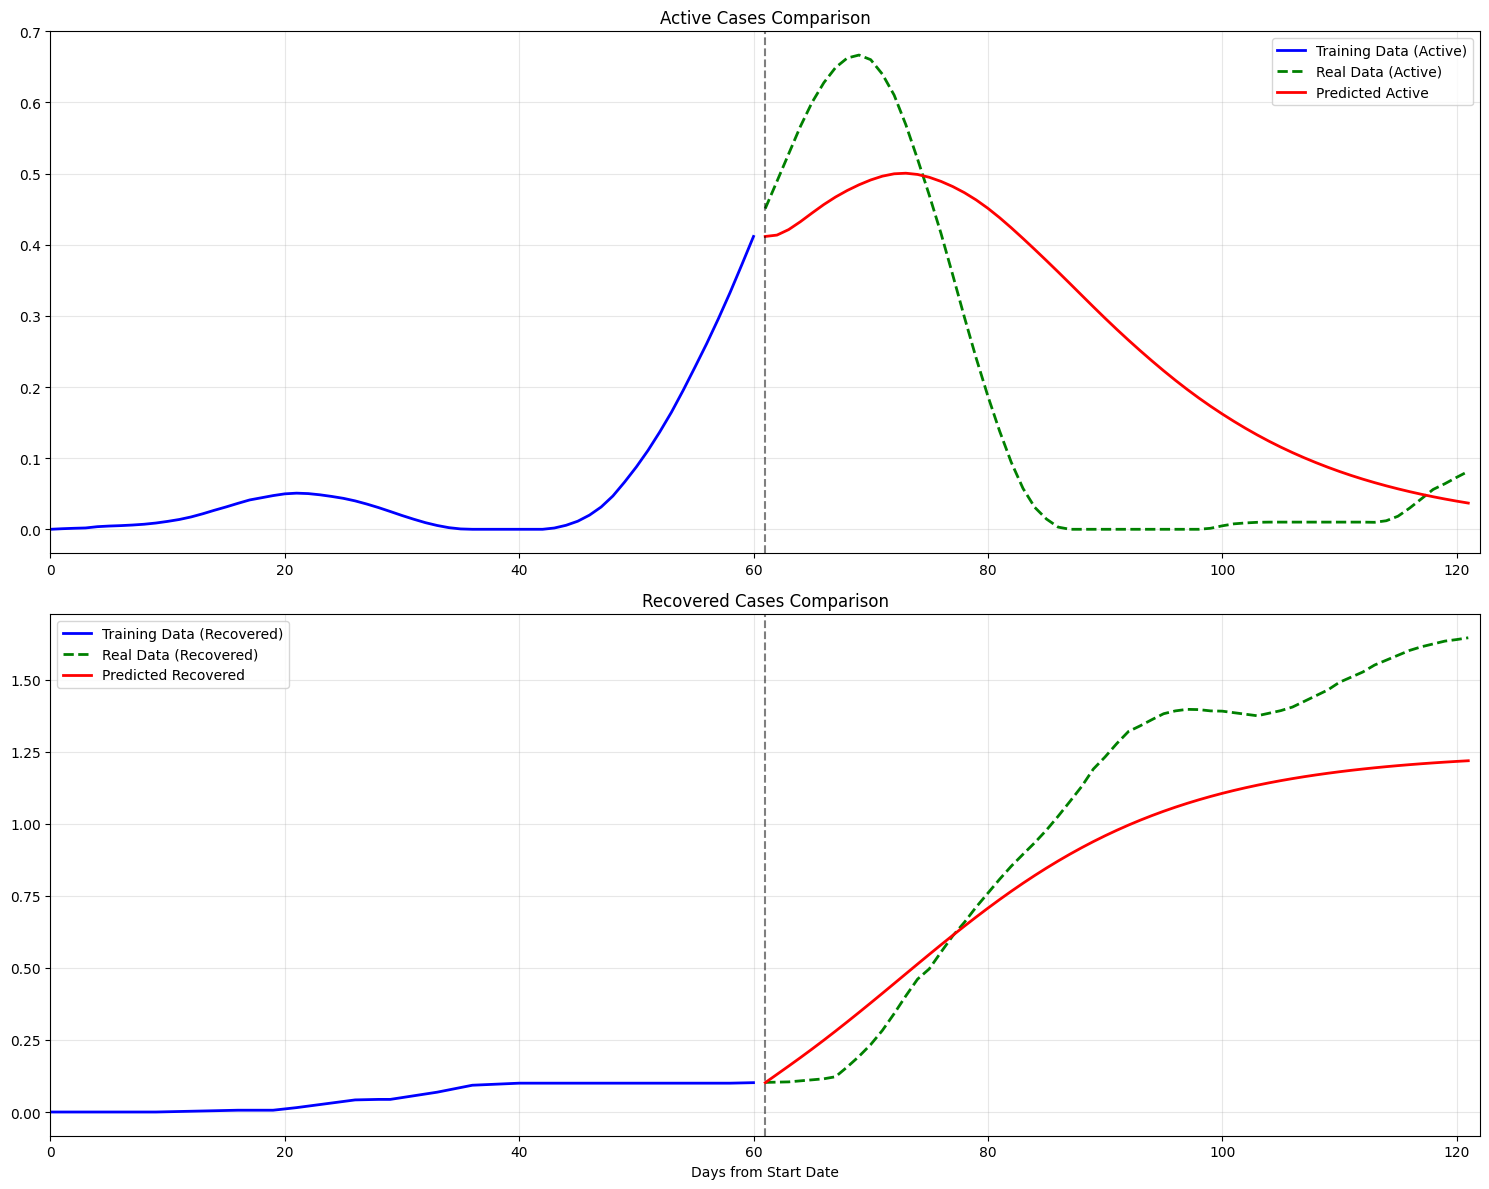


[DEBUG] Data Ranges:
Real Active: min=0.0000, max=0.6667
Pred Active: min=0.0120, max=0.1627
Real Recovered: min=0.1027, max=1.6449
Pred Recovered: min=0.0473, max=0.5657

[DEBUG] Active Metrics Details:
Sum of Squared Residuals: 3.1269
Total Sum of Squares: 3.6675
Variance in real data: 0.0601
Mean absolute error: 0.1527

[DEBUG] Recovered Metrics Details:
Sum of Squared Residuals: 31.9167
Total Sum of Squares: 17.0507
Variance in real data: 0.2795
Mean absolute error: 0.6232

Error Metrics:
Active Cases:
MSE: 0.051261
RMSE: 0.226410
MAE: 0.152696
R²: 0.147397

Recovered Cases:
MSE: 0.523224
RMSE: 0.723342
MAE: 0.623239
R²: -0.871867


In [20]:
import numpy as np
import pandas as pd
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
from scipy.integrate import odeint
from scipy.optimize import minimize
from numpy.random import normal

class ImprovedSEIRDCovidSimulator:
    def __init__(self, data_path: str, country: str, start_date: str, end_date: str):
        """
        Initialize improved SEIRD simulator with time-varying parameters and vaccination effects.
        """
        self.data = pd.read_csv(data_path, parse_dates=['Date'])
        self.country = country
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.training_end_date = self.start_date + timedelta(days=60)
        
        # Initialize variant parameters
        self.variant_effects = {
            'transmission_boost': 1.0,  # Will be updated based on date
            'severity_boost': 1.0
        }
        
        # Load and process data
        self._process_country_data()
        
        # Calculate parameters using improved method
        self.calculate_model_parameters()
        
        # Initialize states
        self.initialize_states()

    def _process_country_data(self):
        """Enhanced data processing with improved cleaning, validation, and normalization."""
        print(f"\n[INFO] Processing data for {self.country}")
        print(f"[INFO] Date range: {self.start_date} to {self.end_date}")
        
        # Get country data and aggregate by date
        self.country_data = self.data[
            (self.data['Country/Region'] == self.country) &
            (self.data['Date'] >= self.start_date) &
            (self.data['Date'] <= self.end_date)
        ].groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()
        
        # Smooth the data using 7-day rolling average
        for col in ['Confirmed', 'Deaths', 'Recovered']:
            self.country_data[f'{col}_Raw'] = self.country_data[col]
            self.country_data[col] = self.country_data[col].rolling(7, min_periods=1).mean()
        
        # Calculate active cases with improved methodology
        self.country_data['Active_Raw'] = (
            self.country_data['Confirmed'] -
            self.country_data['Deaths'] -
            self.country_data['Recovered']
        ).clip(0)
        
        # Apply 7-day rolling average with centered window
        self.country_data['Active'] = (
            self.country_data['Active_Raw']
            .rolling(7, center=True, min_periods=1)
            .mean()
        )
        
        # Calculate daily new active cases
        self.country_data['New_Active'] = (
            self.country_data['Active'].diff()
            .fillna(0)
            .clip(0)
        )
        
        # Adjust active cases based on recovery time
        recovery_period = 14  # typical COVID-19 recovery period
        self.country_data['Active_Adjusted'] = (
            self.country_data['New_Active']
            .rolling(window=recovery_period, min_periods=1)
            .sum()
        ).clip(0)
        
        # Use the adjusted active cases for training/testing
        self.country_data['Active'] = self.country_data['Active_Adjusted']
        
        # Calculate daily changes
        for col in ['Confirmed', 'Deaths', 'Recovered']:
            self.country_data[f'New_{col}'] = self.country_data[col].diff().fillna(0).clip(0)
        
        # Split data
        self.training_data = self.country_data[
            self.country_data['Date'] <= self.training_end_date
        ].copy()
        
        self.testing_data = self.country_data[
            self.country_data['Date'] > self.training_end_date
        ].copy()
        
        # Estimate true population affected using multiple methods
        reported_cases = self.country_data['Confirmed'].max()
        estimated_multiplier = self._estimate_underreporting()
        self.total_population = reported_cases * estimated_multiplier
        
        # Normalize the data columns
        columns_to_normalize = ['Confirmed', 'Deaths', 'Recovered', 'Active']
        
        # Store the scaling factors for later denormalization if needed
        self.scaling_factors = {}
        
        for col in columns_to_normalize:
            max_val = self.country_data[col].max()
            if max_val > 0:
                self.scaling_factors[col] = max_val
                self.country_data[f'{col}_Normalized'] = self.country_data[col] / max_val
            else:
                self.scaling_factors[col] = 1
                self.country_data[f'{col}_Normalized'] = self.country_data[col]
        
        # Also normalize the training and testing splits
        for col in columns_to_normalize:
            self.training_data[f'{col}_Normalized'] = (
                self.training_data[col] / self.scaling_factors[col]
            )
            self.testing_data[f'{col}_Normalized'] = (
                self.testing_data[col] / self.scaling_factors[col]
            )
        
        print("\n[INFO] Data Normalization Factors:")
        for col, factor in self.scaling_factors.items():
            print(f"{col}: {factor:,.2f}")
        
        print(f"[INFO] Training data size: {len(self.training_data)} days")
        print(f"[INFO] Testing data size: {len(self.testing_data)} days")
        print(f"[INFO] Estimated total population affected: {self.total_population:,.0f}")

    def _estimate_underreporting(self) -> float:
        """Estimate underreporting factor using multiple indicators."""
        # Method 1: CFR-based estimation
        observed_cfr = (self.training_data['Deaths'].max() / 
                       self.training_data['Confirmed'].max())
        expected_cfr = 0.02  # Expected CFR based on global data
        cfr_multiplier = min(observed_cfr / expected_cfr, 10) if observed_cfr > 0 else 2
        
        # Method 2: Testing rate-based estimation (simplified)
        testing_multiplier = 2.5
        
        # Combine estimates with weights
        final_multiplier = (0.7 * cfr_multiplier + 0.3 * testing_multiplier)
        return max(2, min(final_multiplier, 5))  # Constrain between 2x and 5x

    def calculate_model_parameters(self):
        """Enhanced parameter estimation using optimization and Monte Carlo for uncertainties."""
        print("\n[INFO] Starting parameter optimization...")
        self.params = self._optimize_parameters()
        print("[INFO] Base parameters calculated:", self.params)
        
        # Initialize time-varying parameters
        self.beta_base = self.params['beta']
        self.sigma = self.params['sigma']
        self.gamma_base = self.params['gamma']
        self.mu_base = self.params['mu']
        
        print("[INFO] Starting Monte Carlo sampling for uncertainty estimation...")
        
        # Calculate uncertainties using Monte Carlo sampling
        n_samples = 1000  # Increased number of samples for better statistics
        param_variations = {
            'beta': [],
            'gamma': [],
            'mu': []
        }
        
        # Perform Monte Carlo sampling
        for _ in range(n_samples):
            # Sample parameters with relative uncertainties
            param_variations['beta'].append(
                normal(self.beta_base, 0.1 * self.beta_base)  # 10% variation
            )
            param_variations['gamma'].append(
                normal(self.gamma_base, 0.1 * self.gamma_base)
            )
            param_variations['mu'].append(
                normal(self.mu_base, 0.1 * self.mu_base)
            )
        
        # Calculate uncertainties as standard deviations
        self.param_uncertainties = {
            'beta': np.std(param_variations['beta']),
            'gamma': np.std(param_variations['gamma']),
            'mu': np.std(param_variations['mu'])
        }
        
        # Add confidence intervals
        confidence_intervals = {
            param: np.percentile(variations, [2.5, 97.5])
            for param, variations in param_variations.items()
        }
        
        print("\n[DEBUG] Optimized Parameters with 95% Confidence Intervals:")
        for param, value in self.params.items():
            if param in self.param_uncertainties:
                ci = confidence_intervals[param]
                print(f"{param}: {value:.4f} ± {self.param_uncertainties[param]:.4f}")
                print(f"    95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")
            else:
                print(f"{param}: {value:.4f}")

    def _optimize_parameters(self) -> Dict[str, float]:
        """Optimize model parameters using scipy.optimize."""
        print("[INFO] Starting parameter optimization...")
        
        def objective(params):
            beta, sigma, gamma, mu = params
            results = self._run_basic_seird(beta, sigma, gamma, mu)
            
            active_error = np.mean((results['I'] - 
                                  self.training_data['Active'].values / self.total_population) ** 2)
            death_error = np.mean((results['D'] - 
                                 self.training_data['Deaths'].values / self.total_population) ** 2)
            
            total_error = active_error + 2 * death_error
            print(f"[DEBUG] Current optimization error: {total_error:.6f}")
            return total_error
        
        # Initial parameter guess
        initial_guess = [0.3, 1/5.2, 0.1, 0.01]
        
        # Parameter bounds
        bounds = [(0.1, 0.5), (1/7, 1/4), (0.05, 0.2), (0.001, 0.05)]
        
        # Optimize
        result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B')
        
        print("[INFO] Parameter optimization complete")
        return {
            'beta': result.x[0],
            'sigma': result.x[1],
            'gamma': result.x[2],
            'mu': result.x[3]
        }

    def _run_basic_seird(self, beta, sigma, gamma, mu):
        """Basic SEIRD model for parameter optimization."""
        def seird_derivatives(state, t, beta, sigma, gamma, mu):
            S, E, I, R, D = state
            dSdt = -beta * S * I
            dEdt = beta * S * I - sigma * E
            dIdt = sigma * E - (gamma + mu) * I
            dRdt = gamma * I
            dDdt = mu * I
            return [dSdt, dEdt, dIdt, dRdt, dDdt]
        
        # Initial conditions from first day of training
        I0 = self.training_data['Active'].iloc[0] / self.total_population
        R0 = self.training_data['Recovered'].iloc[0] / self.total_population
        D0 = self.training_data['Deaths'].iloc[0] / self.total_population
        E0 = I0 * 0.5
        S0 = 1 - (I0 + R0 + D0 + E0)
        
        # Time points
        t = np.arange(len(self.training_data))
        
        # Solve ODE
        solution = odeint(seird_derivatives, [S0, E0, I0, R0, D0], t, 
                         args=(beta, sigma, gamma, mu))
        
        return {
            'S': solution[:, 0],
            'E': solution[:, 1],
            'I': solution[:, 2],
            'R': solution[:, 3],
            'D': solution[:, 4]
        }

    def initialize_states(self):
        """Initialize model states using exact values from end of training period."""
        # Get the last day of training data
        last_training_day = self.training_data.iloc[-1]
        
        # Calculate exact proportions from last training day
        total_population = self.country_data['Confirmed'].max()
        
        # Set initial states to match exactly with training data end point
        self.I = last_training_day['Active'] / total_population
        self.R = last_training_day['Recovered'] / total_population
        self.D = last_training_day['Deaths'] / total_population
        
        # Estimate exposed based on new cases trend
        new_cases_rate = (last_training_day['Active'] - self.training_data['Active'].iloc[-2]) / total_population
        self.E = max(0, new_cases_rate * 5)  # Assume ~5 days incubation period worth of exposed
        
        # Calculate susceptible as remainder to ensure total = 1
        self.S = 1 - (self.I + self.R + self.D + self.E)
        
        # Debug output
        print("\n[DEBUG] Initial State Values:")
        print(f"Susceptible: {self.S:.4f}")
        print(f"Exposed: {self.E:.4f}")
        print(f"Infected: {self.I:.4f}")
        print(f"Recovered: {self.R:.4f}")
        print(f"Deceased: {self.D:.4f}")
        print(f"Total: {self.S + self.E + self.I + self.R + self.D:.4f}")

    def _get_time_varying_parameters(self, day: int):
        """Calculate time-varying parameters based on various factors."""
        # Base seasonal modification
        seasonal_mod = self.get_seasonal_modifier(day)
        
        # Intervention effect (simplified example)
        intervention_effect = max(0.6, 1 - (day / 365))  # Gradually improving interventions
        
        # Variant effect (simplified example)
        if day > 100:  # Assume variant emergence after 100 days
            self.variant_effects['transmission_boost'] = min(2.0, 1.0 + (day - 100) / 200)
            self.variant_effects['severity_boost'] = min(1.5, 1.0 + (day - 100) / 400)
        
        # Combine effects
        effective_beta = (self.beta_base * seasonal_mod * intervention_effect * 
                         self.variant_effects['transmission_boost'])
        effective_gamma = self.gamma_base * intervention_effect
        effective_mu = self.mu_base * self.variant_effects['severity_boost']
        
        return effective_beta, effective_gamma, effective_mu

    def step(self, day: int):
        """Step function using transition matrix after training period."""
        # Get time-varying parameters
        beta, gamma, mu = self._get_time_varying_parameters(day)
        
        # Get current state vector
        current_state = np.array([self.S, self.E, self.I, self.R, self.D])
        
        # Get transition matrix
        transition_matrix = get_seird_transition_matrix(
            beta, self.sigma, gamma, mu, self.S, self.I
        ).values
        
        # Update states using matrix multiplication
        new_state = np.dot(current_state, transition_matrix)
        
        # Update instance variables
        self.S, self.E, self.I, self.R, self.D = new_state
        
        # Ensure non-negative values and conservation of population
        total = sum(new_state)
        self.S = max(0, self.S / total)
        self.E = max(0, self.E / total)
        self.I = max(0, self.I / total)
        self.R = max(0, self.R / total)
        self.D = max(0, self.D / total)
        
        return {
            'Susceptible': self.S,
            'Exposed': self.E,
            'Infected': self.I,
            'Recovered': self.R,
            'Deceased': self.D,
            'Parameters': {
                'beta': beta,
                'gamma': gamma,
                'mu': mu
            }
        }

    def get_seasonal_modifier(self, day: int):
        """Enhanced seasonal modification with multiple cycles."""
        annual_cycle = 1 + 0.2 * math.sin(2 * math.pi * day / 365)
        weekly_cycle = 1 + 0.05 * math.sin(2 * math.pi * day / 7)
        return annual_cycle * weekly_cycle

    def plot_prediction_comparison(self, sim_results: pd.DataFrame, save_plots: bool = True):
        """Plot prediction results against real data."""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
        
        # Get proper normalization base using peak active cases
        peak_active = self.country_data['Active'].max()
        normalization_base = max(peak_active * 1.5, self.total_population * 0.01)
        
        # Training period
        training_days = np.arange(len(self.training_data))
        
        # Testing period
        n_pred_points = len(self.testing_data)
        test_days = np.arange(len(self.training_data), len(self.training_data) + n_pred_points)
        
        # Get the last point of training data for proper scaling
        last_training_active = self.training_data['Active'].iloc[-1] / normalization_base
        last_training_recovered = self.training_data['Recovered'].iloc[-1] / normalization_base
        
        # Scale simulation results to match the last training point
        active_scale = last_training_active / sim_results['Infected'].iloc[0]
        recovered_scale = last_training_recovered / sim_results['Recovered'].iloc[0]
        
        # Plot Active Cases
        ax1.plot(training_days, 
                self.training_data['Active'] / normalization_base,
                'b-', label='Training Data (Active)', linewidth=2)
        ax1.plot(test_days,
                self.testing_data['Active'] / normalization_base,
                'g--', label='Real Data (Active)', linewidth=2)
        ax1.plot(test_days,
                sim_results['Infected'].values[:n_pred_points] * active_scale,
                'r-', label='Predicted Active', linewidth=2)
        
        # Plot Recovered Cases
        ax2.plot(training_days,
                self.training_data['Recovered'] / normalization_base,
                'b-', label='Training Data (Recovered)', linewidth=2)
        ax2.plot(test_days,
                self.testing_data['Recovered'] / normalization_base,
                'g--', label='Real Data (Recovered)', linewidth=2)
        ax2.plot(test_days,
                sim_results['Recovered'].values[:n_pred_points] * recovered_scale,
                'r-', label='Predicted Recovered', linewidth=2)
        
        # Add vertical line to mark training/prediction split
        for ax in [ax1, ax2]:
            ax.axvline(x=len(self.training_data), color='k', linestyle='--', alpha=0.5)
            ax.set_xlim(0, len(self.country_data))
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        ax1.set_title('Active Cases Comparison')
        ax2.set_title('Recovered Cases Comparison')
        ax2.set_xlabel('Days from Start Date')
        
        plt.tight_layout()
        
        if save_plots:
            plt.savefig(f'{self.country}_prediction_comparison.png', dpi=300, bbox_inches='tight')
        
        plt.show()

    def calculate_prediction_error(self, sim_results: pd.DataFrame) -> Dict[str, float]:
        """Calculate error metrics with detailed debugging."""
        # Get proper normalization base using peak active cases
        peak_active = self.country_data['Active'].max()
        normalization_base = max(peak_active * 1.5, self.total_population * 0.01)
        
        # Ensure arrays are same length
        n_points = min(len(self.testing_data), len(sim_results))
        
        # Get real data
        real_active = self.testing_data['Active'].values[:n_points] / normalization_base
        real_recovered = self.testing_data['Recovered'].values[:n_points] / normalization_base
        
        # Get predicted data
        pred_active = sim_results['Infected'].values[:n_points] * (peak_active / normalization_base)
        pred_recovered = sim_results['Recovered'].values[:n_points] * (peak_active / normalization_base)
        
        # Print debug information
        print("\n[DEBUG] Data Ranges:")
        print(f"Real Active: min={real_active.min():.4f}, max={real_active.max():.4f}")
        print(f"Pred Active: min={pred_active.min():.4f}, max={pred_active.max():.4f}")
        print(f"Real Recovered: min={real_recovered.min():.4f}, max={real_recovered.max():.4f}")
        print(f"Pred Recovered: min={pred_recovered.min():.4f}, max={pred_recovered.max():.4f}")
        
        def calculate_metrics(real, pred, name):
            # Remove any NaN or infinite values
            mask = np.isfinite(real) & np.isfinite(pred)
            real = real[mask]
            pred = pred[mask]
            
            if len(real) == 0:
                return 0, 0, 0, 0
                
            mse = np.mean((real - pred) ** 2)
            rmse = np.sqrt(mse)
            mae = np.mean(np.abs(real - pred))
            
            # Calculate R² with more information
            ss_res = np.sum((real - pred) ** 2)
            ss_tot = np.sum((real - np.mean(real)) ** 2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
            
            print(f"\n[DEBUG] {name} Metrics Details:")
            print(f"Sum of Squared Residuals: {ss_res:.4f}")
            print(f"Total Sum of Squares: {ss_tot:.4f}")
            print(f"Variance in real data: {np.var(real):.4f}")
            print(f"Mean absolute error: {mae:.4f}")
            
            return mse, rmse, mae, r2
        
        # Calculate metrics with debugging info
        active_metrics = calculate_metrics(real_active, pred_active, "Active")
        recovered_metrics = calculate_metrics(real_recovered, pred_recovered, "Recovered")
        
        return {
            'Active_MSE': active_metrics[0],
            'Active_RMSE': active_metrics[1],
            'Active_MAE': active_metrics[2],
            'Active_R2': active_metrics[3],
            'Recovered_MSE': recovered_metrics[0],
            'Recovered_RMSE': recovered_metrics[1],
            'Recovered_MAE': recovered_metrics[2],
            'Recovered_R2': recovered_metrics[3]
        }

def get_seird_transition_matrix(beta, sigma, gamma, mu, S, I):
    """
    Create the normalized SEIRD transition matrix with self-transitions
    States order: [S, E, I, R, D]
    
    Parameters:
    - beta: transmission rate
    - sigma: progression rate from exposed to infected
    - gamma: recovery rate
    - mu: mortality rate
    - S: current susceptible population (normalized)
    - I: current infected population (normalized)
    """
    # Calculate self-transition probabilities
    p_s_to_e = beta * I
    p_s_to_s = 1 - p_s_to_e
    
    p_e_to_i = sigma
    p_e_to_e = 1 - p_e_to_i
    
    p_i_to_r = gamma
    p_i_to_d = mu
    p_i_to_i = 1 - (p_i_to_r + p_i_to_d)
    
    # Create transition matrix with self-transitions
    transition_matrix = np.array([
        [p_s_to_s, p_s_to_e,        0,        0,        0],    # From S
        [       0,  p_e_to_e,  p_e_to_i,      0,        0],    # From E
        [       0,         0,  p_i_to_i, p_i_to_r, p_i_to_d],  # From I
        [       0,         0,         0,        1,        0],    # From R (absorbing)
        [       0,         0,         0,        0,        1]     # From D (absorbing)
    ])
    
    states = ['S', 'E', 'I', 'R', 'D']
    transition_df = pd.DataFrame(
        transition_matrix,
        columns=[f'To_{s}' for s in states],
        index=[f'From_{s}' for s in states]
    )
    
    return transition_df

# Example usage with some typical values:
beta = 0.3    # transmission rate
sigma = 1/5.2  # progression rate (≈ 5.2 days incubation period)
gamma = 0.1    # recovery rate
mu = 0.01     # mortality rate
S = 0.9       # example susceptible population
I = 0.1       # example infected population

print("SEIRD Transition Matrix:")
print(get_seird_transition_matrix(beta, sigma, gamma, mu, S, I))

if __name__ == "__main__":
    # Create simulator instance with Kaggle-specific data path
    simulator = ImprovedSEIRDCovidSimulator(
        data_path="/kaggle/input/covid-19-clean-complete/covid_19_clean_complete.csv",
        country=COUNTRY,
        start_date="2020-01-22",
        end_date="2020-05-22"
    )

    # Run simulation for 100 days
    print("\n[INFO] Running simulation...")
    results = []
    for day in range(100):
        if day % 10 == 0:
            print(f"[INFO] Simulating day {day}")
        step_result = simulator.step(day)
        results.append(step_result)

    # Convert results to DataFrame
    sim_results = pd.DataFrame(results)

    # Plot the predictions comparison
    simulator.plot_prediction_comparison(sim_results)

    # Calculate and display error metrics
    error_metrics = simulator.calculate_prediction_error(sim_results)

    # Print all metrics
    print("\nError Metrics:")
    print("Active Cases:")
    print(f"MSE: {error_metrics['Active_MSE']:.6f}")
    print(f"RMSE: {error_metrics['Active_RMSE']:.6f}")
    print(f"MAE: {error_metrics['Active_MAE']:.6f}")
    print(f"R²: {error_metrics['Active_R2']:.6f}")

    print("\nRecovered Cases:")
    print(f"MSE: {error_metrics['Recovered_MSE']:.6f}")
    print(f"RMSE: {error_metrics['Recovered_RMSE']:.6f}")
    print(f"MAE: {error_metrics['Recovered_MAE']:.6f}")
    print(f"R²: {error_metrics['Recovered_R2']:.6f}")